### I'll assume basic knowledge of deep learning. If not, you can google these things... what's a convolution layer, fully connected layer, learning rate, pooling, etc
# Here we're going to train a handwritten digit classifier based on Artificery nets

### pip3 install artificery

In [ ]:
import torch
import torch.utils.data

import torchvision

# Set up Data -- MNIST dataset

## data params

In [3]:
batch_size_train = 1000
batch_size_test = 1000

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print (batch_idx)
print (example_data.shape)
print (example_targets.shape)

0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


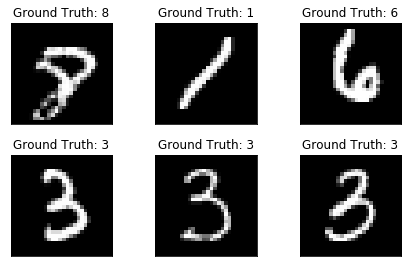

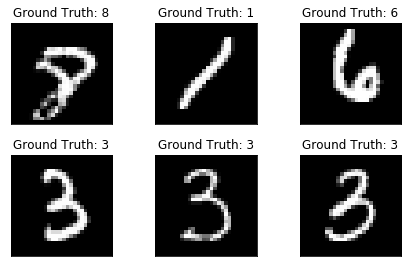

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Build a Net

In [33]:
import importlib
import artificery
#in case you end up playing with artificery code
importlib.reload(artificery)

convblock_spec = {
    "type": "convblock",
    "arch_desc": {
        "fms": [1, 8, 8, 3, 8, 128, 8, 8, 3, 16, 10], # how the number of featuremaps (channels) changes between convs
                                        # we want the output to have 10 features because we have 10 classed
        "act": "relu", # activation function to use. ReLU is pretty good 
        "k": 3, # Kernel Size. All convs in a block have the same kernel size
        #"initc_mult": 0.1, #changes the scale of initial weights for the convolutions
        #"skips": {"1": 3} #adds skip connections between specified convolution
        #"flags": ["instancenorm"] # instancenorm, batchnorm, inputnorm

    }
}

net_spec = {
    "type": "sequence",
    "arch_desc": {
        "module_list": [
            convblock_spec, 
            {"type": "log_softmax"}
        ]
    }
}
a = artificery.Artificery()
net = a.create_net(net_spec)

In [34]:
net #each convblock stores the layers normally and in a sequence, so it's printed twice

Sequential(
  (0): Sequence(
    (layers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (seq): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(

# Network Training

## training params

In [39]:
net = a.create_net(net_spec)
learning_rate = 1.0E-1
momentum = 0.0
n_epochs = 100

In [40]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                      momentum=momentum)

def train(net, epoch, log_interval=1000):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        # I only put padded convolutions in this Net.
        # That means that the output shape is the same as the input shape
        # To get clossification scores, let's look at the middle pixel in the image
        # A clean solution would be to use pooling or a fuuly connected layer.
            # You can figure out how to do it
        output = output[..., output.shape[-2] // 2, output.shape[-1] // 2].squeeze()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(net.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')
    
def test(net):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            # I only put padded convolutions in this Net.
            # That means that the output shape is the same as the input shape
            # To get clossification scores, let's look at the middle pixel in the image
            # A clean solution would be to use pooling or a fuuly connected layer.
            # You can figure out how to do it
            output = output[..., output.shape[-2] // 2, output.shape[-1] // 2].squeeze()
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [41]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
test(net)
for epoch in range(1, n_epochs + 1):
    train(net, epoch)
    test(net)


Test set: Avg. loss: 0.5515, Accuracy: 859/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 5.472806

Test set: Avg. loss: 0.2303, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.303739

Test set: Avg. loss: 0.2301, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.301596


### This trains to achieves decent accuracy, but it's soooo slow to learn
### You can figure out:
    What's the optimal conv setting?
    How to insert pooling layer?
    How to insert a fully connected layer? (you'll have to make your own Artificery parser for that)
    How to plot the loss curve?
    How to compare those curves for different settings?
    Are you using CPU or GPU?
    

In [ ]:
#